In [5]:
import os
import gzip
import time
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd
from pandas.plotting import radviz
from sklearn import preprocessing

# 建立Ann模型
class Ann:
    def __init__(self, inputSize, hidSize, outputSize, learning_rate):
        # 注释以inputSize=4 hidSize=10 outputSize=3为例
        self.inputSize = inputSize          # 输入层
        self.hidSize = hidSize              # 隐藏层
        self.outputSize = outputSize        # 输出层
        self.learning_rate = learning_rate  # 学习率
        # 输入层 -> 隐藏层
        self.w1 = np.random.normal(0.0, pow(hidSize, -0.5), (hidSize, inputSize))      # 权重 w1为【10×4】矩阵，正态分布
        self.b1 = np.zeros((hidSize, 1))                                               # 偏置 b1为【10×1】矩阵，全0
        # 隐藏层 -> 输出层
        self.w2 = np.random.normal(0.0, pow(outputSize, -0.5), (outputSize, hidSize))  # 权重 w2为【3×10】矩阵
        self.b2 = np.zeros((outputSize, 1))                                            # 偏置 b2为【3×1】矩阵
        # sigmoid激活函数
        self.activator = lambda x: 1.0/(1.0+np.exp(-x))

    # 前向传播
    def forward(self):
        # 隐藏层输出值
        self.output1 = self.activator(np.dot(self.w1, self.data) + self.b1)            # output1为【10×1】矩阵，其中data为【4×1】
        # 输出层输出值
        self.output2 = self.activator(np.dot(self.w2, self.output1) + self.b2)         # output2为【3×1】矩阵
        return self.output2

    # 反向传播
    def backward(self):
        # 隐藏层 <- 输出层  g_j
        self.delta2 = self.output2 * (1-self.output2) * (self.label - self.output2)    # delta2为【3×1】矩阵
        # 输入层 <- 隐藏层  e_h
        self.delta1 = self.output1 * (1-self.output1) * np.dot(self.w2.T, self.delta2) # delta1为【10×1】矩阵

    # 计算梯度
    def grad(self):
        # 隐藏层-输出层权重  w_hj && theta_j
        self.w1_grad = np.dot(self.delta2, self.output1.T)   # 权重梯度 w1_grad为【3×10】矩阵
        self.b1_grad = -self.delta2                          # 偏置梯度 b1_grad为【3×1】矩阵
        # 输入层-隐藏层权重  v_ih && gamma_h
        self.w2_grad = np.dot(self.delta1, self.data.T)      # 权重梯度 w2_grad为【10×4】矩阵
        self.b2_grad = -self.delta1                          # 偏置梯度 b1_grad为【10×1】矩阵

    # 更新权重和偏置
    def update(self):
        self.w1 += self.learning_rate * self.w2_grad
        self.b1 += self.learning_rate * self.b2_grad
        self.w2 += self.learning_rate * self.w1_grad
        self.b2 += self.learning_rate * self.b1_grad

    # 训练网络
    def train(self, data, label):
        self.data = np.array(data, ndmin=2).T           # 样本 【4×1】列向量 (最小维度ndmin=2)
        self.label = np.array(label, ndmin=2).T         # 标签 【3×1】列向量
        self.forward()
        self.backward()
        self.grad()
        self.update()

    # 计算准确率
    def accuracy(self, data, labels):
        self.data = np.array(data, ndmin=2).T                       # 输入【4×1】列向量
        self.forward()                                              # 前向传播
        labels_pred = np.argmax(self.output2.T, axis=1)             # 将【3×1】转置为【1×3】，按行取最大值，得到【1×1】输出
        labels_true = np.argmax(labels, axis=1)                     # labels为【1×3】矩阵
        rate = sum(labels_pred == labels_true) / labels.shape[0]    # 求正确率
        error_index = np.arange(0, len(labels_true))
        error_index = error_index[labels_pred != labels_true]       # 得到未正确分类数据的下标
        return rate, labels_pred, labels_true, error_index

# 手写数字识别
def mnist_pred():
    # 读取数据、初始化数据
    def load_data(data_folder, data_name, label_name):
        with gzip.open(os.path.join(data_folder, label_name), 'rb') as lbpath:  # rb表示的是读取二进制数据
            labels = np.frombuffer(lbpath.read(), np.uint8, offset=8)
        with gzip.open(os.path.join(data_folder, data_name), 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), np.uint8, offset=16).reshape(len(labels), 784)
        return images, labels


    class DealDataset():
        def __init__(self, folder, data_name, label_name, transform=None):
            (train_set, train_labels) = load_data(folder, data_name, label_name)  
            self.img = train_set
            self.lab = train_labels
            self.transform = transform

        def __getitem__(self, index):
            imgi, labi = self.img[index], int(self.lab[index])
            if self.transform is not None:
                imgi = self.transform(imgi)
            return imgi, labi

        def __len__(self):
            return len(self.img)


    # 训练数据集
    train_dataset = DealDataset(r'F:\code\data', "train-images-idx3-ubyte.gz","train-labels-idx1-ubyte.gz", transform=transforms.ToTensor())
    # 测试数据集
    test_dataset = DealDataset(r'F:\code\data', "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz", transform=transforms.ToTensor())

    # 训练的图像和标签
    train_images = train_dataset.img
    train_labels = train_dataset.lab
    # 测试的图像和标签
    test_images = test_dataset.img
    test_labels = test_dataset.lab

    # 规范化数据
    train_images = train_images/255
    train_labels = np.eye(10)[train_labels]
    test_images = test_images/255
    test_labels = np.eye(10)[test_labels]

    # 初始化参数
    inputSize=784       # 输入层
    hidSize = 200       # 隐藏层
    outputSize = 10     # 输出层
    learning_rate = 0.1 # 学习率
    epochs = 1          # 训练轮数
    accuracy = []       # 准确率
    # 生成ann模型
    ann = Ann(inputSize, hidSize, outputSize, learning_rate)

    print("开始训练")
    s = time.time()
    for epoch in range(epochs):
        print("第%d轮" % (epoch+1))
        for i in range(len(train_images)):
            if (i+1) % 1000 == 0:
                print("已经训练 %d 张" % (i+1))
                acc, labels_pred, labels_true, error_index = ann.accuracy(test_images, test_labels)
                print('预测值:', labels_pred[0:20], '\n真实值:', labels_true[0:20])
                accuracy.append(acc)
            ann.train(train_images[i], train_labels[i])
    f = time.time()

    print("第%d轮训练结束" % (epoch+1))
    print("当前准确率：", accuracy[-1])
    print("错误下标：", error_index)
    print("耗时：", f-s, 's')
    # 绘制损失图像
    plt.plot(np.arange(1000, len(train_images)+1, 1000), accuracy)
    plt.ylabel('Accuracy')
    plt.xlabel('Number of images')
    plt.show()


def iris_pred():
    # 初始化参数
    inputSize=4             # 输入层
    hidSize = 6            # 隐藏层
    outputSize = 3          # 输出层
    learning_rate = 0.002    # 学习率
    epochs = 2000           # 训练轮数
    accuracy = []           # 准确率
    # 生成ann模型
    ann = Ann(inputSize, hidSize, outputSize, learning_rate)
    # 加载训练数据集
    data_set_path = "F:\code\ML_Lab\lab2_BP\iris_training.csv"
    data_set = pd.read_csv(data_set_path, header=None)
    train_datas = data_set.iloc[:, 0:inputSize].values
    train_labels = data_set.iloc[:, inputSize:].values

    # 加载测试数据集
    data_test_path = "F:\code\ML_Lab\lab2_BP\iris_test.csv"
    data_test_set = pd.read_csv(data_test_path, header=None)
    test_datas = data_test_set.iloc[:, 0:inputSize].values
    test_labels = data_test_set.iloc[:, inputSize:].values


    labels_pred = [] # 预测类别集合
    error_index = [] # 预测错误类别集合
    print("开始训练")
    s = time.time()
    for epoch in range(epochs):
        if (epoch+1) % 100 == 0:
            print("已经训练 %d 轮" % (epoch+1))
            acc, labels_pred, labels_true, error_index = ann.accuracy(test_datas, test_labels)
            print('预测值:', labels_pred, '\n真实值:', labels_true, '\n错误下标:', error_index)
            accuracy.append(acc)
        for i in range(len(train_datas)):
            ann.train(train_datas[i], train_labels[i])
    f = time.time()
    print("第%d轮训练结束" % (epoch+1))
    print("当前准确率：", accuracy[-1])
    print("错误下标：", error_index)
    print("耗时：", f-s, 's')

    # 处理未正确分类的数据，为后续画图准备
    for i in error_index:
        labels_pred[i] = 3

    # 特征有4个维度，类别有1个维度，一共5个维度，故采用了RadViz图
    def result_visualization(test_datas, test_labels, labels_pred, accuracy):
        cols = test_labels.shape[0]
        class_true = []
        class_pred = []

        # 反转换类别的独热编码
        for i in range(cols):
            if test_labels[i][0] == 0 and test_labels[i][1] == 0 and test_labels[i][2] == 1:
                class_true.append('setosa')
            elif test_labels[i][0] == 0 and test_labels[i][1] == 1 and test_labels[i][2] == 0:
                class_true.append('versicolor')
            elif test_labels[i][0] == 1 and test_labels[i][1] == 0 and test_labels[i][2] == 0:
                class_true.append('virginica')

        for j in range(cols):
            if labels_pred[j] == 2:
                class_pred.append('setosa')
            elif labels_pred[j] == 1:
                class_pred.append('versicolor')
            elif labels_pred[j] == 0:
                class_pred.append('virginica')
            else:
                class_pred.append('未知种类')

        # 将特征和类别矩阵拼接起来
        real = np.column_stack((test_datas, class_true))
        pred = np.column_stack((test_datas, class_pred))

        df_real = pd.DataFrame(real, index=None,
                            columns=['萼片长度', '萼片宽度', '花瓣长度', '花瓣宽度', '种类'])
        df_pred = pd.DataFrame(pred, index=None,
                                    columns=['萼片长度', '萼片宽度', '花瓣长度', '花瓣宽度', '种类'])
        df_real[['萼片长度', '萼片宽度', '花瓣长度', '花瓣宽度']] = df_real[
            ['萼片长度', '萼片宽度', '花瓣长度', '花瓣宽度']].astype(float)
        df_pred[['萼片长度', '萼片宽度', '花瓣长度', '花瓣宽度']] = df_pred[
            ['萼片长度', '萼片宽度', '花瓣长度', '花瓣宽度']].astype(float)

        # 绘图
        # 绘制迭代损失图像
        plt.figure("损失图像")
        plt.plot(np.arange(1, epochs, 100), accuracy)
        plt.ylabel('准确率')
        plt.xlabel('迭代次数')
        # 绘制分类图
        plt.figure(dpi=130,figsize=(16,8))
        plt.subplot(1,2,1)
        radviz(df_real, '种类', color=['blue', 'green', 'yellow', 'red'])
        plt.title('真实分类')
        plt.subplot(1,2,2)
        radviz(df_pred, '种类', color=['blue', 'green', 'yellow', 'red'])
        plt.title('预测分类')
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
        plt.rcParams['axes.unicode_minus'] = False
        plt.show()

    result_visualization(test_datas, test_labels, labels_pred, accuracy)


def wine_pred():
    # 初始化参数
    inputSize=13             # 输入层
    hidSize = 10            # 隐藏层
    outputSize = 3          # 输出层
    learning_rate = 0.001    # 学习率
    epochs = 5000           # 训练轮数
    accuracy = []           # 准确率
    # 生成ann模型
    ann = Ann(inputSize, hidSize, outputSize, learning_rate)
    # 加载训练数据集
    data_set_path = "F:\code\ML_Lab\lab2_BP\wine_training.csv"
    data_set = pd.read_csv(data_set_path, header=None)
    train_datas = data_set.iloc[:, 0:inputSize].values
    # 对训练数据做归一化处理【测试数据也同样归一化】
    min_max_scaler = preprocessing.MinMaxScaler()
    train_datas = min_max_scaler.fit_transform(train_datas)
    train_labels = data_set.iloc[:, inputSize:].values

    # 加载测试数据集
    data_test_path = "F:\code\ML_Lab\lab2_BP\wine_test.csv"
    data_test_set = pd.read_csv(data_test_path, header=None)
    test_datas = data_test_set.iloc[:, 0:inputSize].values
    # 测试数据归一化处理
    test_datas = min_max_scaler.fit_transform(test_datas)
    test_labels = data_test_set.iloc[:, inputSize:].values

    labels_pred = [] # 预测类别集合
    error_index = [] # 预测错误类别集合
    print("开始训练")
    s = time.time()
    for epoch in range(epochs):
        if (epoch+1) % 100 == 0:
            print("已经训练 %d 轮" % (epoch+1))
            acc, labels_pred, labels_true, error_index = ann.accuracy(test_datas, test_labels)
            print('预测值:', labels_pred, '\n真实值:', labels_true, '\n错误下标:', error_index)
            accuracy.append(acc)
        for i in range(len(train_datas)):
            ann.train(train_datas[i], train_labels[i])
    f = time.time()
    print("第%d轮训练结束" % (epoch+1))
    print("当前准确率：", accuracy[-1])
    print("错误下标：", error_index)
    print("耗时：", f-s, 's')
    # 绘制损失图像
    plt.figure("损失图像")
    plt.plot(np.arange(1, epochs, 100), accuracy)
    plt.ylabel('准确率')
    plt.xlabel('迭代次数')
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
    plt.rcParams['axes.unicode_minus'] = False
    plt.show()


开始训练
已经训练 100 轮
预测值: [2 2 0 0 0 0 2 0 0 0 2 0 0 2 2 0 2 0 2 0 2 0 0 2 0 0 0 0 0 0] 
真实值: [2 2 1 1 0 1 2 1 1 1 2 1 1 2 2 1 2 1 2 2 2 0 0 2 1 0 0 0 1 1] 
错误下标: [ 2  3  5  7  8  9 11 12 15 17 19 24 28 29]
已经训练 200 轮
预测值: [2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 0 0 0 2 2] 
真实值: [2 2 1 1 0 1 2 1 1 1 2 1 1 2 2 1 2 1 2 2 2 0 0 2 1 0 0 0 1 1] 
错误下标: [ 2  3  5  7  8  9 11 12 15 17 24 28 29]
已经训练 300 轮
预测值: [2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 0 0 0 2 2] 
真实值: [2 2 1 1 0 1 2 1 1 1 2 1 1 2 2 1 2 1 2 2 2 0 0 2 1 0 0 0 1 1] 
错误下标: [ 2  3  5  7  8  9 11 12 15 17 24 28 29]
已经训练 400 轮
预测值: [2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 0 0 0 2 2] 
真实值: [2 2 1 1 0 1 2 1 1 1 2 1 1 2 2 1 2 1 2 2 2 0 0 2 1 0 0 0 1 1] 
错误下标: [ 2  3  5  7  8  9 11 12 15 17 24 28 29]
已经训练 500 轮
预测值: [2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 0 0 0 2 2] 
真实值: [2 2 1 1 0 1 2 1 1 1 2 1 1 2 2 1 2 1 2 2 2 0 0 2 1 0 0 0 1 1] 
错误下标: [ 2  3  5  7  8  9 11 12 15 17 24 28 29]
已经训练 600 轮
预测值: [2 2 2

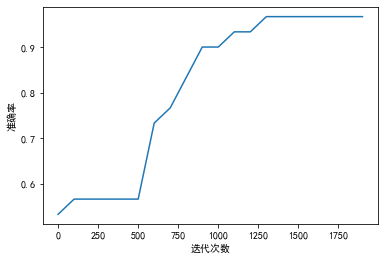

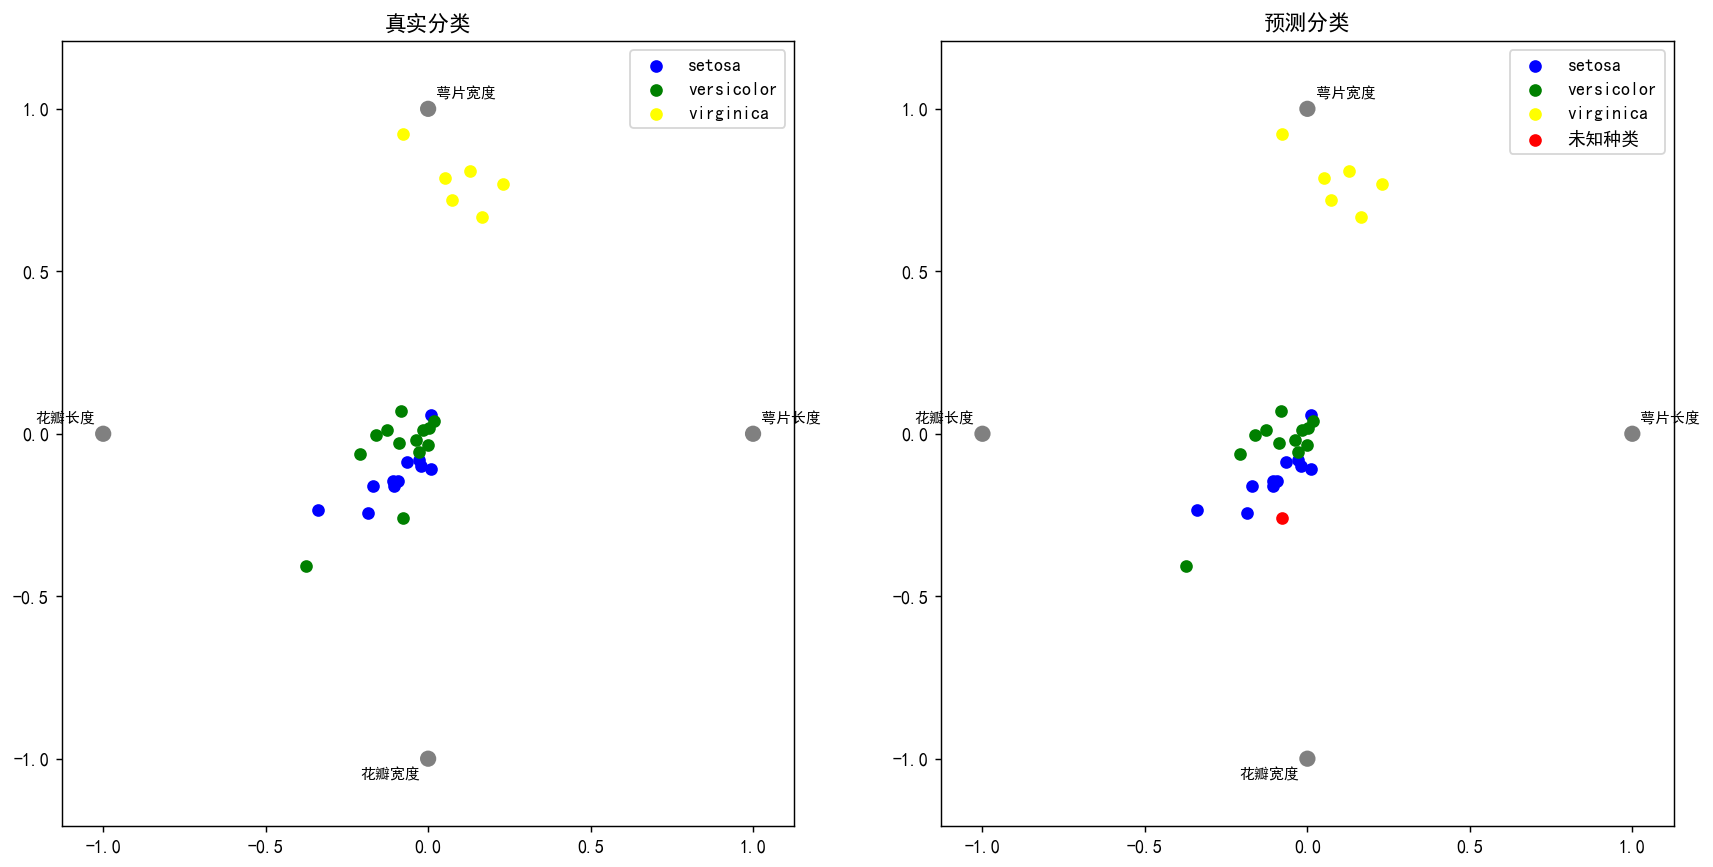

In [9]:
iris_pred() # 鸢尾花识别 4属性3分类

开始训练
已经训练 100 轮
预测值: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
真实值: [1 1 0 2 1 2 0 1 2 1 0 0 2 0 2 2 0 2 1 0 2 0 0 1 0 0 1 0 0 2] 
错误下标: [ 0  1  3  4  5  7  8  9 12 14 15 17 18 20 23 26 29]
已经训练 200 轮
预测值: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
真实值: [1 1 0 2 1 2 0 1 2 1 0 0 2 0 2 2 0 2 1 0 2 0 0 1 0 0 1 0 0 2] 
错误下标: [ 0  1  3  4  5  7  8  9 12 14 15 17 18 20 23 26 29]
已经训练 300 轮
预测值: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
真实值: [1 1 0 2 1 2 0 1 2 1 0 0 2 0 2 2 0 2 1 0 2 0 0 1 0 0 1 0 0 2] 
错误下标: [ 0  1  3  4  5  7  8  9 12 14 15 17 18 20 23 26 29]
已经训练 400 轮
预测值: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
真实值: [1 1 0 2 1 2 0 1 2 1 0 0 2 0 2 2 0 2 1 0 2 0 0 1 0 0 1 0 0 2] 
错误下标: [ 0  1  3  4  5  7  8  9 12 14 15 17 18 20 23 26 29]
已经训练 500 轮
预测值: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
真实值: [1 1 0 2 1 2 0 1 2 1 0 0 2 0 2 2 0 2 1 0 2 0 0 1 0 0 1 0 0 2] 
错误下标: [ 0  1  3  4  5  7

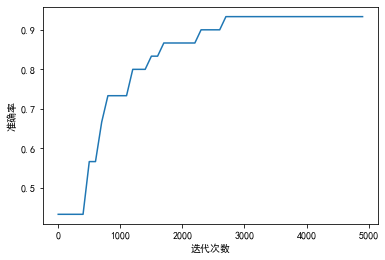

In [6]:
wine_pred() # 红酒数据集识别 13属性3分类

开始训练
第1轮
已经训练 1000 张
预测值: [7 8 1 0 4 1 4 3 2 7 0 3 9 0 1 3 7 7 3 4] 
真实值: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
已经训练 2000 张
预测值: [7 2 1 0 4 1 4 9 2 9 0 4 9 0 1 5 4 7 5 4] 
真实值: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
已经训练 3000 张
预测值: [7 2 1 0 4 1 4 9 6 9 0 8 9 0 1 5 4 7 6 4] 
真实值: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
已经训练 4000 张
预测值: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4] 
真实值: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
已经训练 5000 张
预测值: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 6 4] 
真实值: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
已经训练 6000 张
预测值: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 3 9 7 3 4] 
真实值: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
已经训练 7000 张
预测值: [7 2 1 0 4 1 4 9 6 9 0 0 9 0 1 5 9 7 3 4] 
真实值: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
已经训练 8000 张
预测值: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 6 4] 
真实值: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
已经训练 9000 张
预测值: [7 6 1 0 4 1 4 9 6 9 0 6 9 0 1 5 4 7 3 4] 
真实值: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
已经训练 10000 张
预测值: [7 2 1 0 4

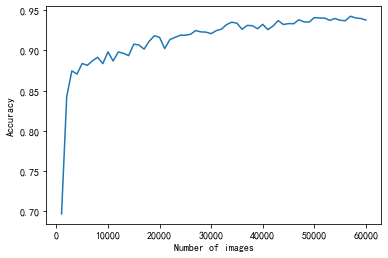

In [12]:
mnist_pred() # 手写数字图像识别 784属性10分类